# Colab-e4e+StyleCLIPglobal

Original: [StyleCLIP-e4e-colab](https://github.com/bycloudai/StyleCLIP-e4e-colab)

My fork: [styler00dollar/Colab-e4e-StyleCLIPglobal](https://github.com/styler00dollar/Colab-e4e-StyleCLIPglobal)

Colab with less boxes/text and model download/copy instructions.

In [ ]:
!nvidia-smi

In [ ]:
#@title Setup
import os
os.chdir('/content')

%tensorflow_version 1.x
#! pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html 

!git clone https://github.com/omertov/encoder4editing.git $CODE_DIR
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force
!pip install -U --no-cache-dir gdown --pre # upgrading gdown to show proper error message

Due to high load, you cant properly test this Colab. Download model and copy it into Colab manually

Face model: https://drive.google.com/uc?id=17faPqBce2m1AQeLCLHUVXaDfxMRU2QcV

Other models: 

```

MODEL_PATHS = {
    "ffhq_encode": {"id": "1cUv_reLE6k3604or78EranS7XzuVMWeO", "name": "e4e_ffhq_encode.pt"},
    "cars_encode": {"id": "17faPqBce2m1AQeLCLHUVXaDfxMRU2QcV", "name": "e4e_cars_encode.pt"},
    "horse_encode": {"id": "1TkLLnuX86B_BMo2ocYD0kX9kWh53rUVX", "name": "e4e_horse_encode.pt"},
    "church_encode": {"id": "1-L0ZdnQLwtdy6-A_Ccgq5uNJGTqE7qBa", "name": "e4e_church_encode.pt"}
}
````

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!cp /content/drive/MyDrive/e4e_ffhq_encode.pt /content/encoder4editing/pretrained_models/e4e_ffhq_encode.pt

TensorFlow 1.x selected.
Loading e4e over the pSp framework from checkpoint: /content/encoder4editing/pretrained_models/e4e_ffhq_encode.pt
Model successfully loaded!
Aligned image has shape: (256, 256)
Inference took 0.1408 seconds.
/root
/content


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-hgztm69f
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-hgztm69f
fatal: destination path 'StyleCLIP' already exists and is not an empty directory.
/root
/content/StyleCLIP/global
Setting up TensorFlow plugin "fused_bias_act.cu": Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Loading... Done.
get all z and w
Generate S
2021-09-03 05:01:16.062132: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-09-03 05:01:16.066619: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-03 05:01:16.067153: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla P100-PCIE-16GB major: 6 minor: 0 memoryClockRate(GHz): 1.3285
pciBus

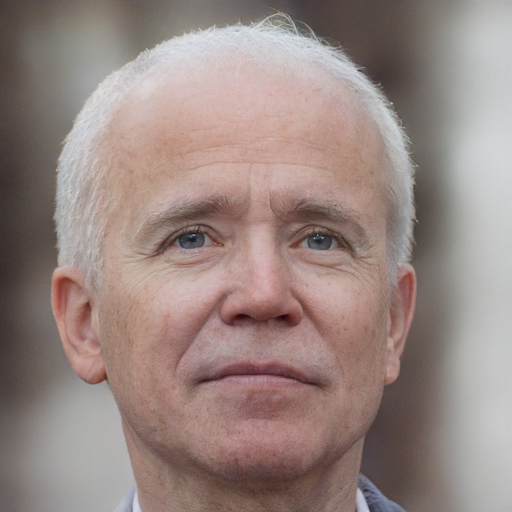

In [1]:
#@title Set path and run this
%tensorflow_version 1.x
import os
CODE_DIR = '/content/encoder4editing'

experiment_type = 'ffhq_encode'
def get_download_model_command(file_id, file_name):
    """ Get wget download command for downloading the desired model and save to directory pretrained_models. """
    current_directory = os.getcwd()
    save_path = os.path.join(os.path.dirname(current_directory), CODE_DIR, "pretrained_models")
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    url = r"""wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id={FILE_ID}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id={FILE_ID}" -O {SAVE_PATH}/{FILE_NAME} && rm -rf /tmp/cookies.txt""".format(FILE_ID=file_id, FILE_NAME=file_name, SAVE_PATH=save_path)
    return url    

MODEL_PATHS = {
    "ffhq_encode": {"id": "1cUv_reLE6k3604or78EranS7XzuVMWeO", "name": "e4e_ffhq_encode.pt"},
    "cars_encode": {"id": "17faPqBce2m1AQeLCLHUVXaDfxMRU2QcV", "name": "e4e_cars_encode.pt"},
    "horse_encode": {"id": "1TkLLnuX86B_BMo2ocYD0kX9kWh53rUVX", "name": "e4e_horse_encode.pt"},
    "church_encode": {"id": "1-L0ZdnQLwtdy6-A_Ccgq5uNJGTqE7qBa", "name": "e4e_church_encode.pt"}
}

path = MODEL_PATHS[experiment_type]
download_command = get_download_model_command(file_id=path["id"], file_name=path["name"]) 

#!wget {download_command}
#%cd /content/encoder4editing/pretrained_models
#!gdown --id 1cUv_reLE6k3604or78EranS7XzuVMWeO
os.chdir(f'{CODE_DIR}')

from argparse import Namespace
import time
import os
import sys
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms

sys.path.append(".")
sys.path.append("..")

from utils.common import tensor2im
from models.psp import pSp  # we use the pSp framework to load the e4e encoder.


image_name = '/content/joe-biden-ehemaliger.jpg' #@param {type:"string"}
os.chdir('/content/encoder4editing')
EXPERIMENT_DATA_ARGS = {
    "ffhq_encode": {
        "model_path": "pretrained_models/e4e_ffhq_encode.pt",
        "image_path": image_name
    }
    
}
# Setup required image transformations
EXPERIMENT_ARGS = EXPERIMENT_DATA_ARGS[experiment_type]
if experiment_type == 'cars_encode':
    EXPERIMENT_ARGS['transform'] = transforms.Compose([
            transforms.Resize((192, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    resize_dims = (256, 192)
else:
    EXPERIMENT_ARGS['transform'] = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    resize_dims = (256, 256)

model_path = "/content/encoder4editing/pretrained_models/e4e_ffhq_encode.pt"
ckpt = torch.load(model_path, map_location='cpu')
opts = ckpt['opts']
# pprint.pprint(opts)  # Display full options used
# update the training options
opts['checkpoint_path'] = model_path
opts= Namespace(**opts)
net = pSp(opts)
net.eval()
net.cuda()
print('Model successfully loaded!')

image_path = EXPERIMENT_DATA_ARGS[experiment_type]["image_path"]
original_image = Image.open(image_path)
original_image = original_image.convert("RGB")
if experiment_type == "ffhq_encode" and 'shape_predictor_68_face_landmarks.dat' not in os.listdir():
    !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    !bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

def run_alignment(image_path):
  import dlib
  from utils.alignment import align_face
  predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
  aligned_image = align_face(filepath=image_path, predictor=predictor) 
  print("Aligned image has shape: {}".format(aligned_image.size))
  return aligned_image 

# run alightemnt if you want
face_alignment_checkbox = True #@param {type:"boolean"}
if face_alignment_checkbox == True:
  input_image = run_alignment(image_path)
else:
  input_image = original_image

input_image.resize(resize_dims)



img_transforms = EXPERIMENT_ARGS['transform']
transformed_image = img_transforms(input_image)

def display_alongside_source_image(result_image, source_image):
    res = np.concatenate([np.array(source_image.resize(resize_dims)),
                          np.array(result_image.resize(resize_dims))], axis=1)
    return Image.fromarray(res)

def run_on_batch(inputs, net):
    images, latents = net(inputs.to("cuda").float(), randomize_noise=False, return_latents=True)
    if experiment_type == 'cars_encode':
        images = images[:, :, 32:224, :]
    return images, latents

with torch.no_grad():
    tic = time.time()
    images, latents = run_on_batch(transformed_image.unsqueeze(0), net)
    result_image, latent = images[0], latents[0]
    toc = time.time()
    print('Inference took {:.4f} seconds.'.format(toc - tic))


torch.save(latents, 'latents.pt')
# Display inversion:
display_alongside_source_image(tensor2im(result_image), input_image)


% cd
% cd /content/


! pip install ftfy regex tqdm 
!pip install git+https://github.com/openai/CLIP.git 
! git clone https://github.com/bycloudai/StyleCLIP

dataset_name='ffhq'
# input dataset name 

%cd
%cd /content/StyleCLIP/global/
# input prepare data 
!python GetCode.py --dataset_name $dataset_name --code_type 'w' 
!python GetCode.py --dataset_name $dataset_name --code_type 's' 
!python GetCode.py --dataset_name $dataset_name --code_type 's_mean_std' 

os.chdir('/content/StyleCLIP/global/')

import tensorflow as tf
import numpy as np 
import torch
import clip
from PIL import Image
import pickle
import copy
import matplotlib.pyplot as plt
from MapTS import GetFs,GetBoundary,GetDt
from manipulate import Manipulator
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device) 

M=Manipulator(dataset_name='ffhq') 
fs3=np.load('./npy/ffhq/fs3.npy')
np.set_printoptions(suppress=True)

latents=torch.load('/content/encoder4editing/latents.pt') # located in the top-level folder in the Colab UI
w_plus=latents.cpu().detach().numpy()
dlatents_loaded=M.W2S(w_plus)

img_index = 0
img_indexs=[img_index]

dlatent_tmp=[tmp[img_indexs] for tmp in dlatents_loaded]
M.num_images=len(img_indexs)

M.alpha=[0]
M.manipulate_layers=[0]
codes,out=M.EditOneC(0, dlatent_tmp) 
original=Image.fromarray(out[0,0]).resize((512,512))
M.manipulate_layers=None
original

0.4268
num of channels being manipulated: 112


(-0.5, 1023.5, 1023.5, -0.5)

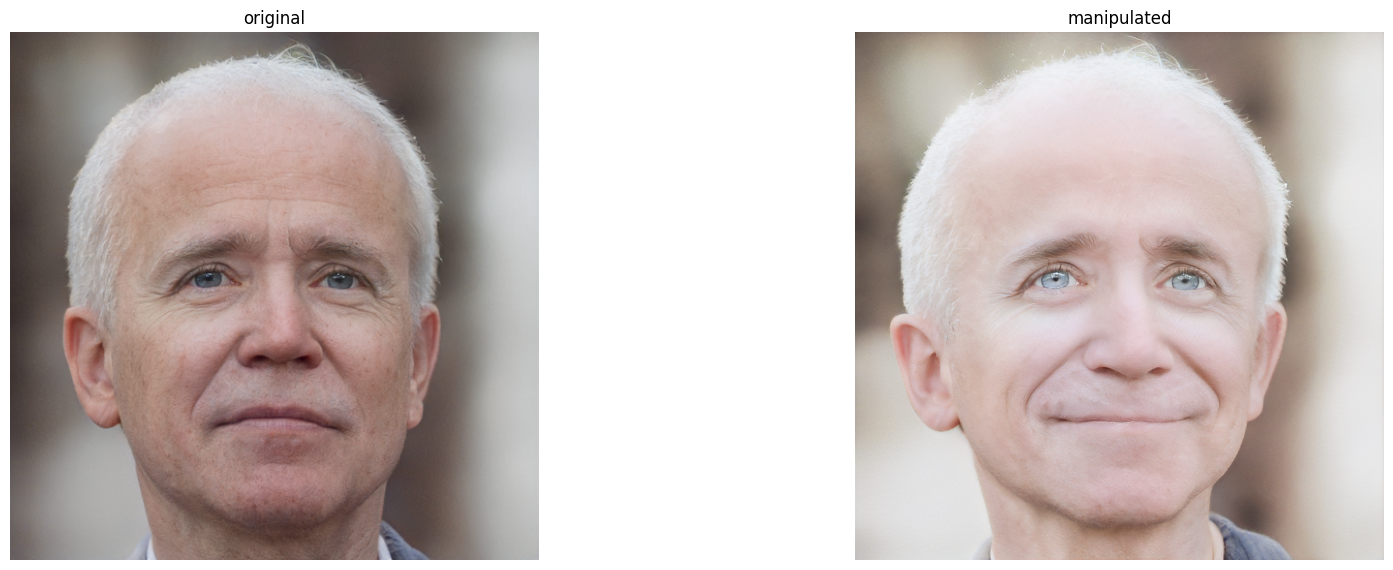

In [6]:
# @title run
neutral='face' #@param {type:"string"}
target='cute eyes' #@param {type:"string"}
classnames=[target,neutral]
dt=GetDt(classnames,model)

#beta=0.1
#alpha=1
beta = 0.08 #@param {type:"slider", min:0.08, max:0.3, step:0.01}
alpha = 6.2 #@param {type:"slider", min:-10, max:10, step:0.1}
M.alpha=[alpha]
boundary_tmp2,c=GetBoundary(fs3,dt,M,threshold=beta)
codes=M.MSCode(dlatent_tmp,boundary_tmp2)
out=M.GenerateImg(codes)
generated=Image.fromarray(out[0,0])#.resize((512,512))


plt.figure(figsize=(20,7), dpi= 100)
plt.subplot(1,2,1)
plt.imshow(original)
plt.title('original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(generated)
plt.title('manipulated')
plt.axis('off')